# Preparing data for Feature Extraction

## Defining imports and constants

In [1]:
import pandas as pd
from anthropic import Anthropic
import tiktoken
import json
from typing import Dict, Tuple, Set, Union, Optional
from pandas.core.series import Series
from pandas.core.frame import DataFrame
from tqdm import tqdm

import numpy as np
from rapidfuzz import fuzz  # pip install rapidfuzz
from fast_langdetect import detect  # pip install fast-langdetect
import re
import nltk
from nltk.corpus import stopwords

In [19]:
# Constants
SIMILARITY_THRESHOLD = 90  # (%)
MIN_DESCRIPTION_LENGTH = 300  # Characters
INVALID_TITLE = "Title not available"  # Invalid title string
MIN_TEXT_LENGTH_FOR_LANG_CHECK = 10  # Characters
MIN_LANG_CONFIDENCE_SCORE = 0.1  # 0-1 float probablity
LENGTH_RATIO_THRESHOLD = 0.7  # 0-1 float probablity
FINGERPRINT_LENGTH = 100  # Characters
HASH_PREFIX_LENGTH = 8  # Characters

# Claude API pricing constants
CLAUDE_INPUT_COST_PER_1M = 0.4
CLAUDE_OUTPUT_COST_PER_1M = 2.0

In [20]:
# Required Columns
REQUIRED_COLUMNS = [
    "query",
    "country",
    "job_description",
    "location",
    "salary",
    "job_title",
    "job_link",
]

In [21]:
# File Paths
INPUT_FILE = "../1scrape/glassdoor.csv"
CLEANED_OUTPUT_FILE = "cleaned_glassdoor.csv"
SIMILAR_DESC_FILE = "similar_descriptions_analysis.csv"
PROBLEMATIC_ENTRIES_FILE = "problematic_entries.csv"

In [22]:
TEMPLATE = """You are a JSON generator. Your task is to analyze this job posting and return ONLY a valid JSON object with no additional text or formatting. Extract the following features:

{
    "soft_skills": ["list", "of", "soft skills"],  // Communication, leadership, teamwork, problem-solving, etc.
    "hard_skills": ["list", "of", "technical skills"],  // Programming languages, tools, frameworks, certifications
    "location_flexibility": "enum",  // Exactly one of: ["remote", "hybrid", "onsite", "unspecified"]
    "contract_type": "enum",  // Exactly one of: ["full-time", "part-time", "contract", "internship", "unspecified"]
    "education_level": "enum",  // Exactly one of: ["high_school", "bachelors", "masters", "phd", "unspecified"]
    "field_of_study": ["list", "of", "field of studies"], // for example: ["computer_science", "software_engineering"]
    "seniority": "enum", // Exactly one of ["junior", "mid-level", "senior", "unspecified"]
    "min_years_experience": number,  // Minimum years required, use -1 if unspecified
    "min_salary": number,  // Minimum salary amount, use -1 if unspecified
    "max_salary": number,  // Maximum salary amount, use -1 if unspecified
    "salary_currency": "string",  // USD, EUR, etc. Use "unspecified" if unclear
    "salary_period": "enum"  // Exactly one of: ["yearly", "monthly", "hourly", "unspecified"]
}

Rules:
1. Return ONLY valid JSON, no explanations or additional text
2. Use exact enum values as specified
3. Use -1 for any numeric fields that cannot be determined
4. Use "unspecified" for any string/enum fields that cannot be determined
5. Always include all fields in the response
6. Lists should be empty [] if no values found
7. Normalize education levels (e.g., "BS", "Bachelor's", "Bachelors" all become "bachelors")
8. Convert all salary amounts to numbers (no currency symbols or commas)"""

In [23]:
# Initialize NLTK resources and patterns
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

STOP_WORDS = set(stopwords.words("english"))
WORD_PATTERN = re.compile(r"\b\w+\b")

## Defining cleaning functions

In [24]:
def find_similar_descriptions(
    df: pd.DataFrame, threshold: float = 85
) -> Tuple[set, list]:
    """Find similar job descriptions using rapid fuzzy matching

    Args:
        df: DataFrame containing job descriptions
        threshold: Similarity threshold (0-100), default 85

    Returns:
        Tuple containing:
        - Set of indices of similar descriptions
        - List of dictionaries containing similarity details
    """
    from rapidfuzz import fuzz
    import hashlib

    if "job_description" not in df.columns:
        raise ValueError("DataFrame must contain 'job_description' column")

    similar_indices = set()
    similarity_details = []  # Will store detailed comparison information

    # Pre-process descriptions to reduce noise and computation
    print("\nPre-processing descriptions...")
    descriptions = df["job_description"].fillna("").str.lower().tolist()

    # Create initial clusters using hash-based blocking
    print("\nCreating initial clusters...")
    clusters = {}
    for idx, desc in enumerate(descriptions):
        # Create a simhash-like fingerprint using first 100 chars
        fingerprint = hashlib.md5(desc[:FINGERPRINT_LENGTH].encode()).hexdigest()[
            :HASH_PREFIX_LENGTH
        ]
        if fingerprint not in clusters:
            clusters[fingerprint] = []
        clusters[fingerprint].append(idx)

    # Compare descriptions only within same clusters
    print("\nChecking for similar descriptions...")
    for cluster in tqdm(clusters.values(), desc="Processing clusters"):
        if len(cluster) < 2:
            continue

        for i in range(len(cluster)):
            desc1 = descriptions[cluster[i]]
            # Only compare with subsequent descriptions in cluster
            for j in range(i + 1, len(cluster)):
                desc2 = descriptions[cluster[j]]

                # Quick length comparison first
                len_ratio = min(len(desc1), len(desc2)) / max(len(desc1), len(desc2))
                if (
                    len_ratio < LENGTH_RATIO_THRESHOLD
                ):  # Skip if lengths are too different
                    continue

                # Use token_sort_ratio for better handling of word order differences
                similarity = fuzz.token_sort_ratio(desc1, desc2)

                if similarity >= threshold:
                    similar_indices.add(cluster[i])
                    similar_indices.add(cluster[j])

                    # Store detailed information about the similarity match
                    similarity_details.append(
                        {
                            "index1": cluster[i],
                            "index2": cluster[j],
                            "similarity_score": similarity,
                            "job_title1": df.iloc[cluster[i]]["job_title"],
                            "job_title2": df.iloc[cluster[j]]["job_title"],
                            "location1": df.iloc[cluster[i]]["location"],
                            "location2": df.iloc[cluster[j]]["location"],
                            "salary1": df.iloc[cluster[i]]["salary"],
                            "salary2": df.iloc[cluster[j]]["salary"],
                            "description1": df.iloc[cluster[i]]["job_description"],
                            "description2": df.iloc[cluster[j]]["job_description"],
                        }
                    )

    return similar_indices, similarity_details

In [25]:
def is_non_english(text: str, min_score: float = 0.1) -> bool:
    """check if text is likely non-english using fast language detection

    args:
        text: text to analyze
        min_score: minimum confidence score threshold for english (default: 0.1)

    returns:
        true if text is likely non-english, false otherwise
    """
    if not isinstance(text, str) or len(text.strip()) < MIN_TEXT_LENGTH_FOR_LANG_CHECK:
        return False

    try:
        # remove newlines to prevent valueerror
        text = text.replace("\n", " ")
        result = detect(text, low_memory=True)
        # check if english is detected with sufficient confidence
        return not (
            result["lang"] == "en" and result["score"] >= MIN_LANG_CONFIDENCE_SCORE
        )
    except:
        return False

In [26]:
def analyze_glassdoor_data() -> Tuple[pd.DataFrame, Set[int]]:
    # Read the CSV file
    print("\nReading glassdoor.csv...")
    df = pd.read_csv(INPUT_FILE)

    # Ensure string columns are not None
    df["job_description"] = df["job_description"].fillna("")
    df["salary"] = df["salary"].fillna("")
    df["job_title"] = df["job_title"].fillna("")
    df["location"] = df["location"].fillna("")

    # Basic information about the dataset
    print("\n=== BASIC INFORMATION ===")
    print(f"Total number of rows: {len(df)}")
    print(f"Total number of columns: {len(df.columns)}")
    print("\nColumns:", df.columns.tolist())

    # Check for missing values
    print("\n=== MISSING VALUES ===")
    missing_values = df.isnull().sum()
    missing_percentages = (missing_values / len(df)) * 100
    missing_info = pd.DataFrame(
        {
            "Missing Count": missing_values,
            "Missing Percentage": missing_percentages.round(2),
        }
    )
    print(missing_info[missing_info["Missing Count"] > 0])
    print(
        "Not removing rows with missing values in location and job_title. Not necessary for feature extraction"
    )

    # Check for duplicates
    print("\n=== DUPLICATES ===")
    duplicates = df.duplicated().sum()
    print(f"Total duplicate rows: {duplicates}")

    # Check for duplicate job links (same job posted multiple times)
    duplicate_links = df[df.duplicated(subset=["job_link"], keep=False)]
    print(f"Rows with duplicate job links: {len(duplicate_links)}")

    # Value distributions
    print("\n=== VALUE DISTRIBUTIONS ===")
    print("\nCountry distribution:")
    print(df["country"].value_counts())

    print("\nTop 10 job titles:")
    print(df["job_title"].value_counts().head(10))

    # Check for potential data quality issues
    print("\n=== POTENTIAL DATA QUALITY ISSUES ===")

    # Check for non-English content in descriptions
    print("\nChecking for non-English content...")
    tqdm.pandas(desc="Job descriptions")
    desc_mask = df["job_description"].progress_apply(is_non_english)
    non_english_rows = df[desc_mask]
    print(
        f"\nJobs with likely non-English content in descriptions: {len(non_english_rows)}"
    )

    # Check for very short or empty descriptions
    short_desc = df[df["job_description"].str.len() < MIN_DESCRIPTION_LENGTH]
    print(
        f"Jobs with very short descriptions (<{MIN_DESCRIPTION_LENGTH} chars): {len(short_desc)}"
    )

    # Check for invalid salaries (if they don't contain numbers)
    invalid_salaries = df[~df["salary"].str.contains(r"\d", na=True)]
    print(f"Jobs with potentially invalid salaries: {len(invalid_salaries)}")

    # Check for unusual locations
    print("\nUnique locations found:")
    print(df["location"].value_counts().head(10))

    # Find similar job descriptions
    print("\nAnalyzing similar job descriptions...")
    similar_indices, similarity_details = find_similar_descriptions(
        df, threshold=SIMILARITY_THRESHOLD
    )
    print(f"\nFound {len(similar_indices)} jobs with similar descriptions")

    # Create and save detailed similarity report
    if similarity_details:
        similar_df = pd.DataFrame(similarity_details)
        similar_df.sort_values("similarity_score", ascending=False, inplace=True)

        # Save to CSV with detailed comparison information
        output_file = "similar_descriptions_analysis.csv"
        similar_df.to_csv(output_file, index=False)
        print(f"\nSaved detailed similarity analysis to '{output_file}'")

        # Print summary statistics of similarity scores
        print("\nSimilarity Score Statistics:")
        print(similar_df["similarity_score"].describe())

        # Print sample of most similar pairs
        print("\nTop 5 Most Similar Pairs:")
        for _, row in similar_df.head().iterrows():
            print(f"\nSimilarity Score: {row['similarity_score']:.2f}")
            print(f"Title 1: {row['job_title1']} | Title 2: {row['job_title2']}")
            print(f"Location 1: {row['location1']} | Location 2: {row['location2']}")
            print(
                f"Description 1: {row['description1'][:200]} |\n Description 2: {row['description2'][:200]}"
            )

    indices_to_remove = set()
    if similarity_details:
        # Group by index1 to find all similar descriptions
        for details in similarity_details:
            if details["similarity_score"] >= SIMILARITY_THRESHOLD:
                # Always keep index1 and remove index2
                indices_to_remove.add(details["index2"])

    # Remove the similar descriptions from the dataframe
    df.drop(index=indices_to_remove, inplace=True)
    print(f"\nRemoved {len(indices_to_remove)} similar descriptions")

    # Save problematic entries to a separate CSV for review
    # Convert columns to pandas Series explicitly to ensure proper method access
    job_desc_series = pd.Series(df["job_description"], dtype=str)
    salary_series = pd.Series(df["salary"], dtype=str)

    problematic = df[
        (df.isnull().any(axis=1))  # Any missing values
        | (df.duplicated())  # Duplicates
        | (
            job_desc_series.fillna("").str.len() < MIN_DESCRIPTION_LENGTH
        )  # Short descriptions
        | (~salary_series.fillna("").str.contains(r"\d"))  # Invalid salaries
        | (job_desc_series.apply(is_non_english))  # Non-English content in description
    ].copy()  # Create a copy to avoid SettingWithCopyWarning

    if len(problematic) > 0:
        # Add a column to indicate why entries are problematic
        problematic.loc[:, "issues"] = ""
        problematic.loc[problematic.isnull().any(axis=1), "issues"] += "missing_values;"
        problematic.loc[problematic.duplicated(), "issues"] += "duplicate_entry;"
        problematic.loc[
            problematic["job_description"].fillna("").str.len()
            < MIN_DESCRIPTION_LENGTH,
            "issues",  # type: ignore
        ] += "short_description;"
        problematic.loc[
            ~problematic["salary"].fillna("").str.contains(r"\d"), "issues"  # type: ignore
        ] += "invalid_salary;"
        problematic.loc[problematic["job_title"] == INVALID_TITLE, "issues"] += (
            "invalid_title;"
        )
        print("\nTagging problematic entries...")

        print("Checking job descriptions for non-English content...")
        tqdm.pandas(desc="Checking job descriptions")
        problematic.loc[
            problematic["job_description"].progress_apply(is_non_english), "issues"  # type: ignore
        ] += "non_english_description;"

        problematic.to_csv("problematic_entries.csv", index=True)
        print(
            f"\nSaved {len(problematic)} problematic entries to 'problematic_entries.csv'"
        )

        # Print summary of issues
        print("\nBreakdown of issues:")
        for issue in [
            "missing_values",
            "duplicate_entry",
            "short_description",
            "invalid_salary",
            "non_english_description",
            "invalid_title",
        ]:
            count = problematic["issues"].str.contains(issue).sum()  # type: ignore
            print(f"- {issue}: {count} entries")

    # Remove problematic entries
    print("\nRemoving problematic entries...")
    clean_df = df[
        ~(df.duplicated())  # Remove duplicates
        & (
            df["job_description"].str.len() >= MIN_DESCRIPTION_LENGTH
        )  # Remove short descriptions
        & (df["salary"].str.contains(r"\d", na=False))  # Remove invalid salaries
        & (df["job_title"] != INVALID_TITLE)  # Remove invalid titles
        & ~(df.index.isin(indices_to_remove))  # Remove similar descriptions
        & ~(desc_mask)  # Remove non-English content
    ]

    print(f"\nRemoved {len(df) - len(clean_df)} total problematic entries")

    # Save cleaned data to CSV
    print("\nSaving cleaned data...")
    clean_df.to_csv(CLEANED_OUTPUT_FILE, index=False)
    print(f"Saved {len(clean_df)} cleaned records to '{CLEANED_OUTPUT_FILE}'")

    return clean_df, indices_to_remove

In [27]:
def count_tokens(text: str) -> int:
    """Count tokens using tiktoken"""
    encoding = tiktoken.get_encoding("cl100k_base")  # Claude's encoding
    return len(encoding.encode(text))


def calculate_claude_cost(input_tokens: int, output_tokens: int) -> Dict[str, float]:
    """Calculate Claude API cost based on token usage"""
    # https://www.anthropic.com/pricing#anthropic-api
    input_cost_per_1m = CLAUDE_INPUT_COST_PER_1M
    output_cost_per_1m = CLAUDE_OUTPUT_COST_PER_1M

    input_cost = (input_tokens / 1_000_000) * input_cost_per_1m
    output_cost = (output_tokens / 1_000_000) * output_cost_per_1m
    total_cost = input_cost + output_cost

    return {
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "input_cost": round(input_cost, 4),
        "output_cost": round(output_cost, 4),
        "total_cost": round(total_cost, 4),
    }

In [28]:
def remove_stopwords(text: str) -> str:
    """Remove stopwords from text using regex splitting"""
    if not isinstance(text, str):
        return ""
    # Use regex to split text into words and filter stopwords
    return " ".join(
        word for word in WORD_PATTERN.findall(text.lower()) if word not in STOP_WORDS
    )


def analyze_token_usage():
    """Analyze token usage and cost for EDA processing"""
    print("\n=== TOKEN USAGE ANALYSIS ===")

    # Read the CSV file
    df = pd.read_csv(INPUT_FILE)

    # Initialize counters
    original_input_tokens = 0
    original_output_tokens = 0
    filtered_input_tokens = 0
    filtered_output_tokens = 0

    print("\nCalculating original token usage...")

    template_tokens = count_tokens(TEMPLATE)
    print(f"\nTemplate tokens (per request): {template_tokens}")

    # First calculate original tokens with progress bar
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Counting original tokens"):
        original_prompt = f"""
        Job Title: {row['job_title']}
        Location: {row['location']}
        Salary: {row['salary']}
        Description: {row['job_description']}
        """

        # Calculate tokens for original text
        original_input = template_tokens + count_tokens(original_prompt)
        original_input_tokens += original_input

    # Calculate and display original costs first
    original_cost = calculate_claude_cost(original_input_tokens, original_output_tokens)

    print("\n=== ORIGINAL TEXT TOKEN USAGE AND COST ===")
    print(f"Input Tokens: {original_cost['input_tokens']:,}")
    print(f"Output Tokens: {original_cost['output_tokens']:,}")
    print(f"Input Cost: ${original_cost['input_cost']:,.2f}")
    print(f"Output Cost: ${original_cost['output_cost']:,.2f}")
    print(f"Total Cost: ${original_cost['total_cost']:,.2f}")

    print("\nCalculating filtered token usage (removing stopwords)...")

    # Now calculate filtered tokens with progress bar
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Removing stopwords"):
        filtered_prompt = f"""
        Job Title: {remove_stopwords(str(row['job_title']))}
        Location: {remove_stopwords(str(row['location']))}
        Salary: {str(row['salary'])}
        Description: {remove_stopwords(str(row['job_description']))}
        """

        # Calculate tokens for filtered text
        filtered_input = template_tokens + count_tokens(filtered_prompt)
        filtered_input_tokens += filtered_input

        # Estimate output tokens (same for both since output format doesn't change)
        sample_output = {
            "soft_skills": ["communication", "teamwork"],
            "hard_skills": ["python", "sql"],
            "location_flexibility": "remote",
            "contract_type": "full-time",
            "education_level": "bachelors",
            "field_of_study": "computer science",
            "seniority": "mid-level",
            "min_years_experience": 3,
            "min_salary": 80000,
            "max_salary": 120000,
            "salary_currency": "USD",
            "salary_period": "yearly",
        }
        output_tokens = count_tokens(json.dumps(sample_output))
        original_output_tokens += output_tokens
        filtered_output_tokens += output_tokens

    # Calculate costs for original text
    original_cost = calculate_claude_cost(original_input_tokens, original_output_tokens)

    # Calculate costs for filtered text
    filtered_cost = calculate_claude_cost(filtered_input_tokens, filtered_output_tokens)

    print("\n=== FILTERED TEXT (STOPWORDS REMOVED) TOKEN USAGE AND COST ===")
    print(f"Input Tokens: {filtered_cost['input_tokens']:,}")
    print(f"Output Tokens: {filtered_cost['output_tokens']:,}")
    print(f"Input Cost: ${filtered_cost['input_cost']:,.2f}")
    print(f"Output Cost: ${filtered_cost['output_cost']:,.2f}")
    print(f"Total Cost: ${filtered_cost['total_cost']:,.2f}")

    # Calculate and display savings
    token_reduction = original_cost["input_tokens"] - filtered_cost["input_tokens"]
    cost_savings = original_cost["total_cost"] - filtered_cost["total_cost"]
    reduction_percentage = (token_reduction / original_cost["input_tokens"]) * 100

    print("\n=== SAVINGS ANALYSIS ===")
    print(f"Token Reduction: {token_reduction:,} tokens ({reduction_percentage:.1f}%)")
    print(f"Cost Savings: ${cost_savings:.2f}")

    # The cost is not substantial, around 22.2% savings. I would prefer to retain the stopwords so that the GenAI understands job desription.


def recalculate_analysis(df: pd.DataFrame) -> None:
    """Recalculate basic information and distributions after cleaning"""
    print("\n=== RECALCULATED ANALYSIS AFTER CLEANING ===")

    # Basic information
    print("\n=== UPDATED BASIC INFORMATION ===")
    print(f"Total number of rows: {len(df)}")
    print(f"Total number of columns: {len(df.columns)}")

    # Updated value distributions
    print("\n=== UPDATED VALUE DISTRIBUTIONS ===")
    print("\nCountry distribution:")
    print(df["country"].value_counts())

    print("\nTop 10 job titles:")
    print(df["job_title"].value_counts().head(10))

    print("\n=== RAW DATA TOKEN USAGE ===")
    analyze_token_usage()

    # Recalculate token usage and costs
    print("\n=== RECALCULATED TOKEN USAGE ===")
    template_tokens = count_tokens(TEMPLATE)  # Same template as before

    input_tokens = 0
    output_tokens = 0

    for _, row in tqdm(
        df.iterrows(), total=len(df), desc="Calculating cleaned token usage"
    ):
        cleaned_prompt = f"""
        Job Title: {str(row['job_title'])}
        Location: {str(row['location'])}
        Salary: {str(row['salary'])}
        Description: {str(row['job_description'])}
        """

        input_tokens += template_tokens + count_tokens(cleaned_prompt)

        # Estimate output tokens using sample output
        sample_output = {
            "soft_skills": ["communication", "teamwork"],
            "hard_skills": ["python", "sql"],
            "location_flexibility": "remote",
            "contract_type": "full-time",
            "education_level": "bachelors",
            "field_of_study": "computer science",
            "seniority": "mid-level",
            "min_years_experience": 3,
            "min_salary": 80000,
            "max_salary": 120000,
            "salary_currency": "USD",
            "salary_period": "yearly",
        }
        output_tokens += count_tokens(json.dumps(sample_output))

    # Calculate final costs
    final_cost = calculate_claude_cost(input_tokens, output_tokens)

    print("\n=== FINAL TOKEN USAGE AND COST ===")
    print(f"Input Tokens: {final_cost['input_tokens']:,}")
    print(f"Output Tokens: {final_cost['output_tokens']:,}")
    print(f"Input Cost: ${final_cost['input_cost']:,.2f}")
    print(f"Output Cost: ${final_cost['output_cost']:,.2f}")
    print(f"Total Cost: ${final_cost['total_cost']:,.2f}")

In [29]:
# Run initial analysis which includes finding and removing similar descriptions
clean_df, indices_to_remove = analyze_glassdoor_data()

# Recalculate analysis with clean data
recalculate_analysis(clean_df)


Reading glassdoor.csv...

=== BASIC INFORMATION ===
Total number of rows: 57902
Total number of columns: 7

Columns: ['query', 'country', 'job_description', 'location', 'salary', 'job_title', 'job_link']

=== MISSING VALUES ===
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
Not removing rows with missing values in location and job_title. Not necessary for feature extraction

=== DUPLICATES ===
Total duplicate rows: 0
Rows with duplicate job links: 0

=== VALUE DISTRIBUTIONS ===

Country distribution:
country
US    23073
IN    19989
SG    14840
Name: count, dtype: int64

Top 10 job titles:
job_title
Title not available     651
Data Engineer           192
Software Engineer       165
Data Analyst            159
Software Developer      123
Video Editor            118
Business Analyst        106
Network Engineer         96
Full Stack Developer     96
Graphic Designer         89
Name: count, dtype: int64

=== POTENTIAL DATA QUALITY ISSUES ===

Checking for non-Englis

Job descriptions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57902/57902 [00:09<00:00, 5808.94it/s]



Jobs with likely non-English content in descriptions: 73
Jobs with very short descriptions (<300 chars): 1117
Jobs with potentially invalid salaries: 69

Unique locations found:
location
Singapore         10511
Bengaluru          2999
Remote             2274
Gurgaon            1140
Mumbai             1133
Hyderābād          1079
United States       989
Pune                859
New York, NY        744
Washington, DC      702
Name: count, dtype: int64

Analyzing similar job descriptions...

Pre-processing descriptions...

Creating initial clusters...

Checking for similar descriptions...


Processing clusters: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37231/37231 [00:34<00:00, 1072.63it/s]



Found 24314 jobs with similar descriptions

Saved detailed similarity analysis to 'similar_descriptions_analysis.csv'

Similarity Score Statistics:
count    105298.000000
mean         99.875888
std           0.877598
min          90.002469
25%         100.000000
50%         100.000000
75%         100.000000
max         100.000000
Name: similarity_score, dtype: float64

Top 5 Most Similar Pairs:

Similarity Score: 100.00
Title 1: Software Engineer | Title 2: Software Engineer
Location 1: Sterling Heights, MI | Location 2: Sterling Heights, MI
Description 1: What’s your passion?
At American Rheinmetall Vehicles, we’re driven by technology, and we’re using it to alter the landscape of today’s modern battlespace in order to provide our soldiers with the equ |
 Description 2: What’s your passion?
At American Rheinmetall Vehicles, we’re driven by technology, and we’re using it to alter the landscape of today’s modern battlespace in order to provide our soldiers with the equ

Similarity Scor

Checking job descriptions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:00<00:00, 19448.05it/s]


Saved 733 problematic entries to 'problematic_entries.csv'

Breakdown of issues:
- missing_values: 0 entries
- duplicate_entry: 0 entries
- short_description: 612 entries
- invalid_salary: 66 entries
- non_english_description: 63 entries
- invalid_title: 6 entries

Removing problematic entries...



/var/folders/jc/mky5brlx03z7bnn4kgbmdqhm0000gp/T/ipykernel_19176/1506752843.py:178: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df = df[



Removed 936 total problematic entries

Saving cleaned data...
Saved 41515 cleaned records to 'cleaned_glassdoor.csv'

=== RECALCULATED ANALYSIS AFTER CLEANING ===

=== UPDATED BASIC INFORMATION ===
Total number of rows: 41515
Total number of columns: 7

=== UPDATED VALUE DISTRIBUTIONS ===

Country distribution:
country
US    18950
IN    14259
SG     8306
Name: count, dtype: int64

Top 10 job titles:
job_title
Data Engineer           116
Data Analyst             95
Software Engineer        86
Software Developer       84
Business Analyst         82
Video Editor             72
Network Engineer         69
Full Stack Developer     68
Data Scientist           65
Graphic Designer         60
Name: count, dtype: int64

=== RAW DATA TOKEN USAGE ===

=== TOKEN USAGE ANALYSIS ===

Calculating original token usage...

Template tokens (per request): 479


Counting original tokens: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57902/57902 [00:09<00:00, 5822.32it/s]



=== ORIGINAL TEXT TOKEN USAGE AND COST ===
Input Tokens: 65,320,381
Output Tokens: 0
Input Cost: $26.13
Output Cost: $0.00
Total Cost: $26.13

Calculating filtered token usage (removing stopwords)...


Removing stopwords: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57902/57902 [00:13<00:00, 4420.85it/s]



=== FILTERED TEXT (STOPWORDS REMOVED) TOKEN USAGE AND COST ===
Input Tokens: 50,526,225
Output Tokens: 6,021,808
Input Cost: $20.21
Output Cost: $12.04
Total Cost: $32.25

=== SAVINGS ANALYSIS ===
Token Reduction: 14,794,156 tokens (22.6%)
Cost Savings: $5.92

=== RECALCULATED TOKEN USAGE ===


Calculating cleaned token usage: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41515/41515 [00:08<00:00, 4917.37it/s]


=== FINAL TOKEN USAGE AND COST ===
Input Tokens: 47,160,714
Output Tokens: 4,317,560
Input Cost: $18.86
Output Cost: $8.64
Total Cost: $27.50


# Sending to claude

In [30]:
import os
from typing import Dict, List, Optional
import json
from tqdm import tqdm
import anthropic
import asyncio
from concurrent.futures import ThreadPoolExecutor

In [31]:
class JobFeatureExtractor:
    def __init__(self):
        self.client = anthropic.Anthropic()

    async def extract_features_batch(self, descriptions: List[Dict]):
        """Extract features from multiple job descriptions using Claude"""
        # Prepare batch requests
        requests = []
        for idx, desc in enumerate(descriptions):
            prompt = f"""You are a JSON generator. Your task is to analyze this job posting and return ONLY a valid JSON object with no additional text or formatting. Here is the job posting:

Job Title: {desc['job_title']}
Location: {desc['location']}
Salary: {desc['salary']}
Country: {desc['country']}
Description: {desc['job_description']}

Extract and return ONLY this JSON structure:

{{
    "soft_skills": ["list", "of", "soft skills"],  // Communication, leadership, teamwork, problem-solving, etc.
    "hard_skills": ["list", "of", "technical skills"],  // Programming languages, tools, frameworks, certifications
    "location_flexibility": "enum",  // Exactly one of: ["remote", "hybrid", "onsite", "unspecified"]
    "contract_type": "enum",  // Exactly one of: ["full-time", "part-time", "contract", "internship", "unspecified"]
    "education_level": "enum",  // Exactly one of: ["high_school", "bachelors", "masters", "phd", "unspecified"]
    "field_of_study": ["list", "of", "field of studies"], // for example: ["computer_science", "software_engineering"]
    "seniority": "enum", // Exactly one of ["junior", "mid-level", "senior", "unspecified"]
    "min_years_experience": number,  // Minimum years required, use -1 if unspecified
    "min_salary": number,  // Minimum salary amount, use -1 if unspecified
    "max_salary": number,  // Maximum salary amount, use -1 if unspecified
    "salary_period": "enum"  // Exactly one of: ["yearly", "monthly", "hourly", "unspecified"]
}}

Rules:
1. Return ONLY valid JSON, no explanations or additional text
2. Use exact enum values as specified
3. Use -1 for any numeric fields that cannot be determined
4. Use "unspecified" for any string/enum fields that cannot be determined
5. Always include all fields in the response
6. Lists should be empty [] if no values found
7. Normalize education levels (e.g., "BS", "Bachelor's", "Bachelors" all become "bachelors")
8. Convert all salary amounts to numbers (no currency symbols or commas)
9. Use the provided salary information to determine salary details when available"""

            requests.append(
                anthropic.types.messages.batch_create_params.Request(  # type: ignore
                    custom_id=f"job_{idx}",
                    params=anthropic.types.message_create_params.MessageCreateParamsNonStreaming(
                        model="claude-3-5-haiku-latest",
                        max_tokens=1024,
                        temperature=0,
                        messages=[{"role": "user", "content": prompt}],
                    ),
                )
            )

        try:
            # Print request details
            print("\nSending batch request to Anthropic:")
            print(f"Number of messages in batch: {len(requests)}")

            # Create batch request and store the response
            message_batch = await asyncio.get_event_loop().run_in_executor(
                ThreadPoolExecutor(),
                lambda: self.client.messages.batches.create(requests=requests),
            )
            self.message_batch = message_batch  # Store for later reference

            # Print response details
            print("\nReceived response from Anthropic:")
            print(f"Batch ID: {message_batch.id}")
            print(f"Created at: {message_batch.created_at}")
            print(f"Expires at: {message_batch.expires_at}")

            # Save the complete message_batch response
            # Convert datetime objects to ISO format strings
            batch_info = {
                "id": message_batch.id,
                "type": message_batch.type,
                "processing_status": message_batch.processing_status,
                "request_counts": {
                    "processing": message_batch.request_counts.processing,
                    "succeeded": message_batch.request_counts.succeeded,
                    "errored": message_batch.request_counts.errored,
                    "canceled": message_batch.request_counts.canceled,
                    "expired": message_batch.request_counts.expired,
                },
                "ended_at": message_batch.ended_at.isoformat()
                if message_batch.ended_at
                else None,
                "created_at": message_batch.created_at.isoformat()
                if message_batch.created_at
                else None,
                "expires_at": message_batch.expires_at.isoformat()
                if message_batch.expires_at
                else None,
                "cancel_initiated_at": message_batch.cancel_initiated_at.isoformat()
                if message_batch.cancel_initiated_at
                else None,
                "results_url": message_batch.results_url,
            }

            with open("batch_tracking.json", "w") as f:
                json.dump(batch_info, f, indent=2)

            print("\nBatch tracking information saved to batch_tracking.json")
            print("Batch successfully submitted! Exiting without polling.")

            return

        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return

In [33]:
async def main():
    # Read cleaned CSV file
    print("Loading cleaned Glassdoor data...")
    glassdoor_df = pd.read_csv(CLEANED_OUTPUT_FILE)
    print(f"Loaded {len(glassdoor_df)} cleaned job listings")

    try:
        # Try to load existing progress
        processed_files = [
            f
            for f in os.listdir("results")
            if f.startswith("batch_") and f.endswith(".csv")
        ]
        if processed_files:
            processed_rows = sum(
                [len(pd.read_csv(f"results/{f}")) for f in processed_files]
            )
            print(
                f"Found {processed_rows} processed rows across {len(processed_files)} batch files"
            )
            df = glassdoor_df.iloc[processed_rows:]
        else:
            print("No existing processed batches found. Starting from beginning...")
            df = glassdoor_df
            processed_rows = 0

        if len(df) == 0:
            print("All rows have been processed! Combining results...")
            # Combine all batch files into final result
            all_batches = [pd.read_csv(f"results/{f}") for f in processed_files]
            final_df = pd.concat(all_batches, ignore_index=True)
            final_df.to_csv("anthropic_features.csv", index=False)
            print(
                f"Successfully combined all batches into anthropic_features.csv with {len(final_df)} rows"
            )
            return

    except FileNotFoundError:
        print("No existing anthropic.csv found. Creating new anthropic.csv file...")
        df = glassdoor_df
        existing_eda_df = None
        empty_df = pd.DataFrame(
            columns=[
                "query",
                "country",
                "job_description",
                "location",
                "salary",
                "job_title",
                "job_link",
                "soft_skills",
                "hard_skills",
                "location_flexibility",
                "contract_type",
                "education_level",
                "field_of_study",
                "seniority",
                "min_years_experience",
                "min_salary",
                "max_salary",
                "salary_period",
            ]  # type: ignore
        )
        empty_df.to_csv("anthropic.csv", index=False)
        print("Created empty anthropic.csv with headers")

    # Initialize feature extractor
    extractor = JobFeatureExtractor()

    # Reset index of remaining rows to process
    df = df.reset_index(drop=True)

    # Print total number of jobs to process
    total_jobs = len(df)
    print(f"\nProcessing all {total_jobs} jobs in a single batch request")

    # Prepare all prompts
    prompts = [row.to_dict() for _, row in df.iterrows()]

    # Extract features for all jobs
    print("Submitting batch request...")
    await extractor.extract_features_batch(prompts)

    print(f"Batch submitted! ID: {extractor.message_batch.id}")
    print("You can now use poll_batch.py to check status and retrieve results")

# we will not run this code, we have already sent the request via feature_extraction.py

# Polling for the batch

In [34]:
import anthropic
import json
import time
import pandas as pd
import os
from datetime import datetime

In [40]:
def load_batch_info():
    with open("batch_tracking.json", "r") as f:
        return json.load(f)

def poll_batch():
    client = anthropic.Anthropic()
    batch_info = load_batch_info()

    if batch_info["processing_status"] == "ended":
        print("Batch already completed!")
        return

    print(f"Polling batch {batch_info['id']}...")

    while True:
        message_batch = client.messages.batches.retrieve(batch_info["id"])

        # Print current status
        print(f"\nStatus: {message_batch.processing_status}")
        print(f"Processing: {message_batch.request_counts.processing}")
        print(f"Succeeded: {message_batch.request_counts.succeeded}")
        print(f"Errored: {message_batch.request_counts.errored}")
        print(f"Canceled: {message_batch.request_counts.canceled}")
        print(f"Expired: {message_batch.request_counts.expired}")

        if message_batch.ended_at:
            print(f"Ended at: {message_batch.ended_at}")
        print(f"Created at: {message_batch.created_at}")
        print(f"Expires at: {message_batch.expires_at}")

        if message_batch.results_url:
            print(f"Results URL: {message_batch.results_url}")

        # Save the latest status
        batch_info = {
            "id": message_batch.id,
            "type": message_batch.type,
            "processing_status": message_batch.processing_status,
            "request_counts": {
                "processing": message_batch.request_counts.processing,
                "succeeded": message_batch.request_counts.succeeded,
                "errored": message_batch.request_counts.errored,
                "canceled": message_batch.request_counts.canceled,
                "expired": message_batch.request_counts.expired,
            },
            "ended_at": message_batch.ended_at.isoformat()
            if message_batch.ended_at
            else None,
            "created_at": message_batch.created_at.isoformat()
            if message_batch.created_at
            else None,
            "expires_at": message_batch.expires_at.isoformat()
            if message_batch.expires_at
            else None,
            "cancel_initiated_at": message_batch.cancel_initiated_at.isoformat()
            if message_batch.cancel_initiated_at
            else None,
            "results_url": message_batch.results_url,
        }

        with open("batch_tracking.json", "w") as f:
            json.dump(batch_info, f, indent=2)

        if message_batch.processing_status == "ended":
            print("\nBatch processing complete!")
            return True

        time.sleep(10)


def retrieve_results(batch_id):
    client = anthropic.Anthropic()


    print(f"Retrieving results for batch {batch_id}...")

    # Create results directory
    os.makedirs("results", exist_ok=True)

    # Process results
    all_results = []
    success_count = 0
    error_count = 0

    for result in client.messages.batches.results(batch_id):
        if result.result.type == "succeeded":
            try:
                response_text = result.result.message.content[0].text.strip()
                json_data = json.loads(response_text)
                all_results.append(
                    {
                        "custom_id": result.custom_id,
                        "status": "success",
                        "data": json_data,
                    }
                )
                success_count += 1
            except Exception as e:
                error_count += 1
                all_results.append(
                    {"custom_id": result.custom_id, "status": "error", "error": str(e)}
                )
        else:
            error_count += 1
            all_results.append(
                {
                    "custom_id": result.custom_id,
                    "status": "error",
                    "error": result.result.type,
                }
            )

        # Save progress every 1000 results
        if len(all_results) % 1000 == 0:
            print(f"Processed {len(all_results)} results...")

    # Save final results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"results/batch_results_{timestamp}.json"

    with open(results_file, "w") as f:
        json.dump(all_results, f, indent=2)

    print(f"\nResults saved to {results_file}")
    print(f"Successful results: {success_count}")
    print(f"Failed results: {error_count}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(
        [
            {
                "job_id": result["custom_id"],
                "soft_skills": ",".join(result["data"]["soft_skills"])
                if result["status"] == "success"
                else "",
                "hard_skills": ",".join(result["data"]["hard_skills"])
                if result["status"] == "success"
                else "",
                "location_flexibility": result["data"]["location_flexibility"]
                if result["status"] == "success"
                else "",
                "contract_type": result["data"]["contract_type"]
                if result["status"] == "success"
                else "",
                "education_level": result["data"]["education_level"]
                if result["status"] == "success"
                else "",
                "field_of_study": ",".join(result["data"]["field_of_study"])
                if result["status"] == "success"
                else "",
                "seniority": result["data"]["seniority"]
                if result["status"] == "success"
                else "",
                "min_years_experience": result["data"]["min_years_experience"]
                if result["status"] == "success"
                else None,
                "min_salary": result["data"]["min_salary"]
                if result["status"] == "success"
                else None,
                "max_salary": result["data"]["max_salary"]
                if result["status"] == "success"
                else None,
                "salary_period": result["data"]["salary_period"]
                if result["status"] == "success"
                else "",
            }
            for result in all_results
        ]
    )

    # Read the cleaned Glassdoor data
    glassdoor_df = pd.read_csv(CLEANED_OUTPUT_FILE)

    # Add job_id column to match with results
    glassdoor_df["job_id"] = glassdoor_df.index.map(lambda x: f"job_{x}")

    # Merge the dataframes
    merged_df = pd.merge(glassdoor_df, results_df, on="job_id", how="left")

    # Save the merged dataset
    merged_df.to_csv("jobs.csv", index=False)
    print("\nMerged results saved to jobs.csv")
    print(f"Total rows in final dataset: {len(merged_df)}")



poll_batch()

Batch already completed!


In [39]:
client = anthropic.Anthropic()
print("\nListing all message batches...")

try:
    batches = client.messages.batches.list()

    print("\nCompleted Batches:")
    print("-----------------")
    for batch in batches.data:
        print(f"\nBatch ID: {batch.id}")
        print(f"Status: {batch.processing_status}")
        print(f"Created: {batch.created_at}")
        print(f"Requests - Total: {sum(batch.request_counts.__dict__.values())}")
        print(f"         - Succeeded: {batch.request_counts.succeeded}")
        print(f"         - Failed: {batch.request_counts.errored}")
        print(
            f"Results URL: {batch.results_url if batch.results_url else 'Not available'}"
        )
        print("-----------------")

except Exception as e:
    print(f"Error listing batches: {str(e)}")




Listing all message batches...

Completed Batches:
-----------------

Batch ID: msgbatch_01Jw26bsXE2DDKnHLtPFJFLq
Status: ended
Created: 2025-01-18 17:15:03.217942+00:00
Requests - Total: 41515
         - Succeeded: 41515
         - Failed: 0
Results URL: https://api.anthropic.com/v1/messages/batches/msgbatch_01Jw26bsXE2DDKnHLtPFJFLq/results
-----------------

Batch ID: msgbatch_01Vahfh7ATQcjwF2YGMccMvi
Status: ended
Created: 2025-01-18 17:07:15.604029+00:00
Requests - Total: 100
         - Succeeded: 100
         - Failed: 0
Results URL: https://api.anthropic.com/v1/messages/batches/msgbatch_01Vahfh7ATQcjwF2YGMccMvi/results
-----------------

Batch ID: msgbatch_01ASsSHbPtq5MZ2yoHgYHaZ5
Status: ended
Created: 2025-01-18 17:00:43.426675+00:00
Requests - Total: 50
         - Succeeded: 50
         - Failed: 0
Results URL: https://api.anthropic.com/v1/messages/batches/msgbatch_01ASsSHbPtq5MZ2yoHgYHaZ5/results
-----------------

Batch ID: msgbatch_01Bsmkwg245TMMAhaW5d7dgv
Status: ended
Cr

In [41]:
retrieve_results("msgbatch_01Jw26bsXE2DDKnHLtPFJFLq")

Retrieving results for batch msgbatch_01Jw26bsXE2DDKnHLtPFJFLq...
Processed 1000 results...
Processed 2000 results...
Processed 3000 results...
Processed 4000 results...
Processed 5000 results...
Processed 6000 results...
Processed 7000 results...
Processed 8000 results...
Processed 9000 results...
Processed 10000 results...
Processed 11000 results...
Processed 12000 results...
Processed 13000 results...
Processed 14000 results...
Processed 15000 results...
Processed 16000 results...
Processed 17000 results...
Processed 18000 results...
Processed 19000 results...
Processed 20000 results...
Processed 21000 results...
Processed 22000 results...
Processed 23000 results...
Processed 24000 results...
Processed 25000 results...
Processed 26000 results...
Processed 27000 results...
Processed 28000 results...
Processed 29000 results...
Processed 30000 results...
Processed 31000 results...
Processed 32000 results...
Processed 33000 results...
Processed 34000 results...
Processed 35000 results..

Done! Use 'show' commands to display/save.   |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| [100%]   00:00 -> (00:00 left)



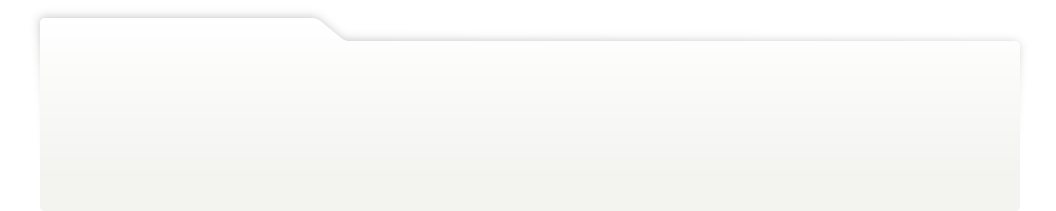
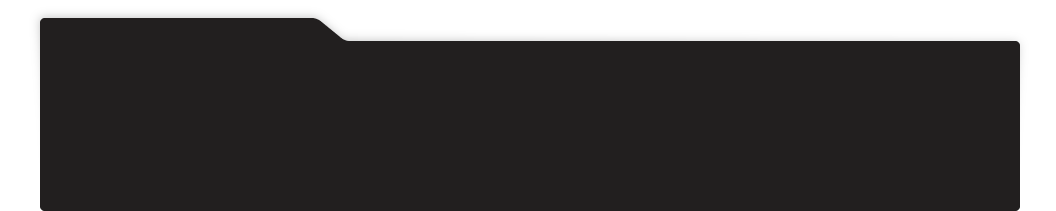
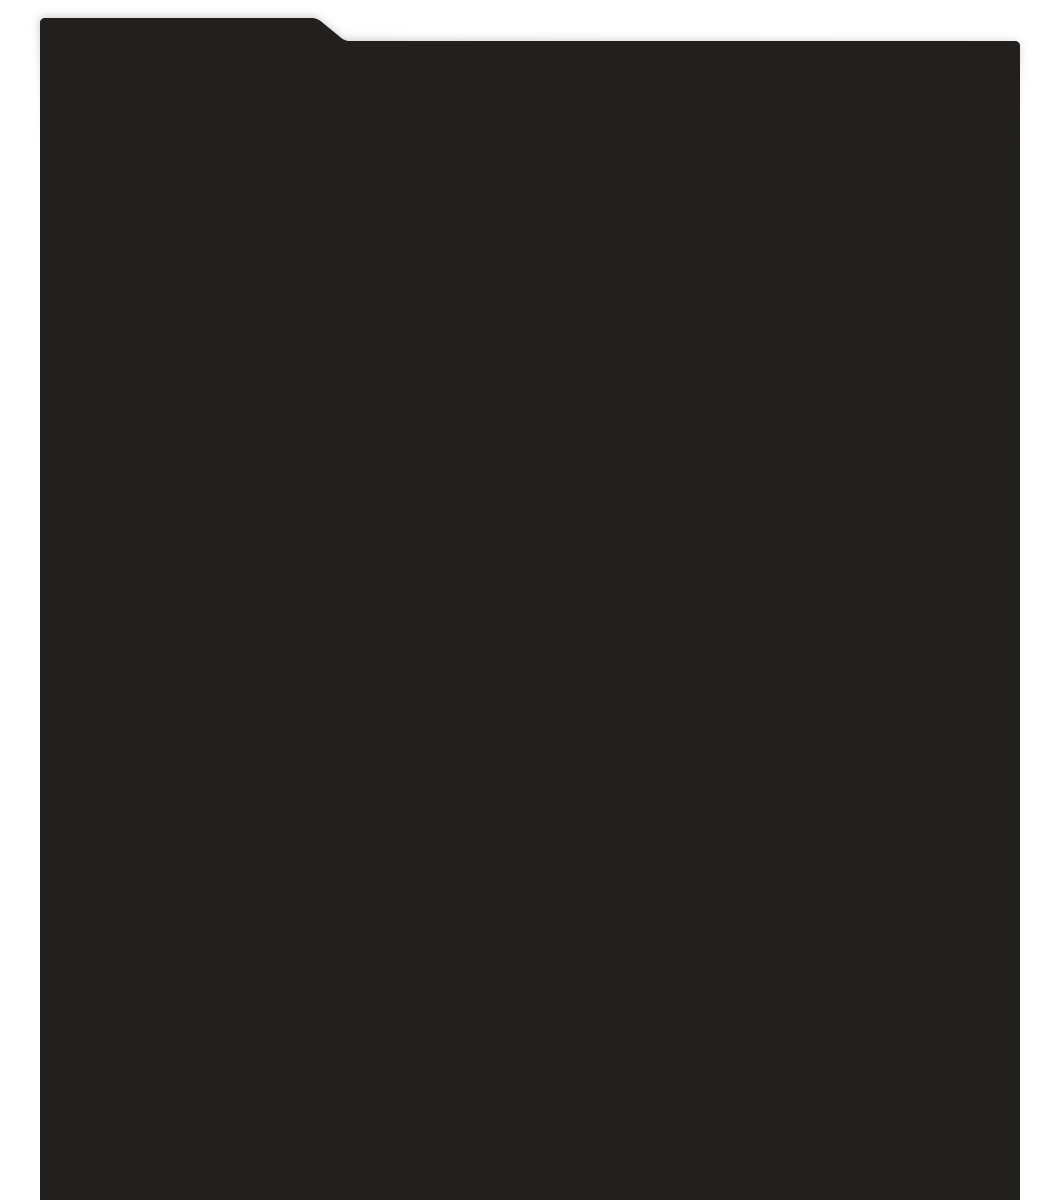
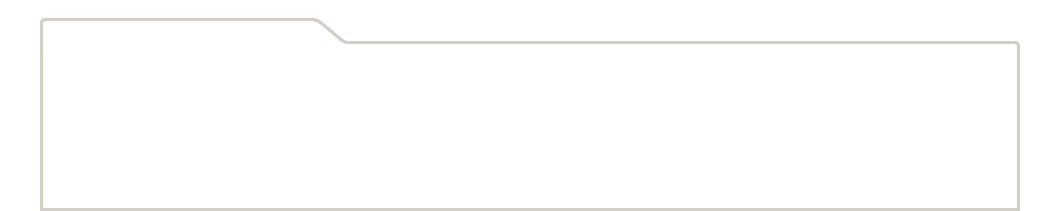
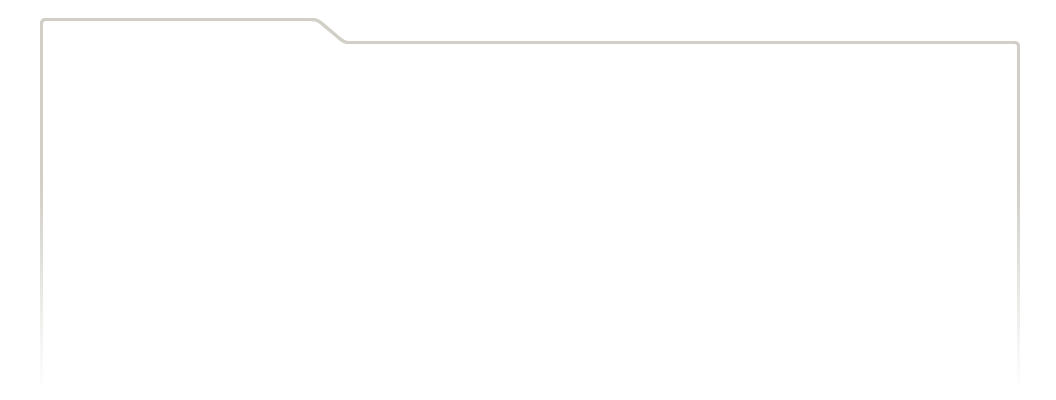
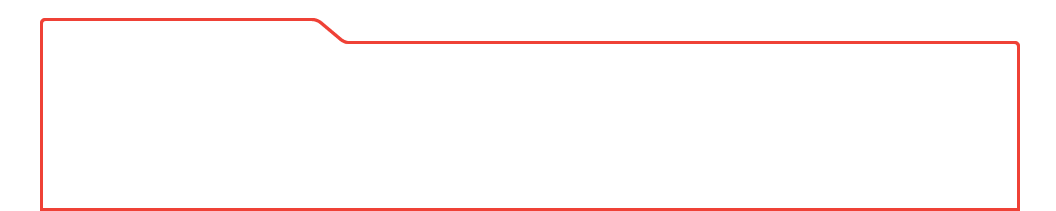
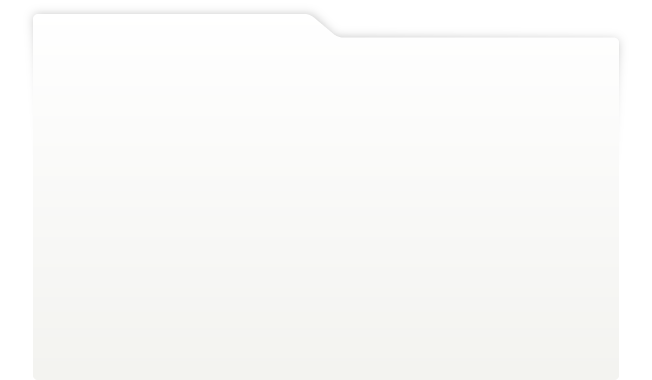
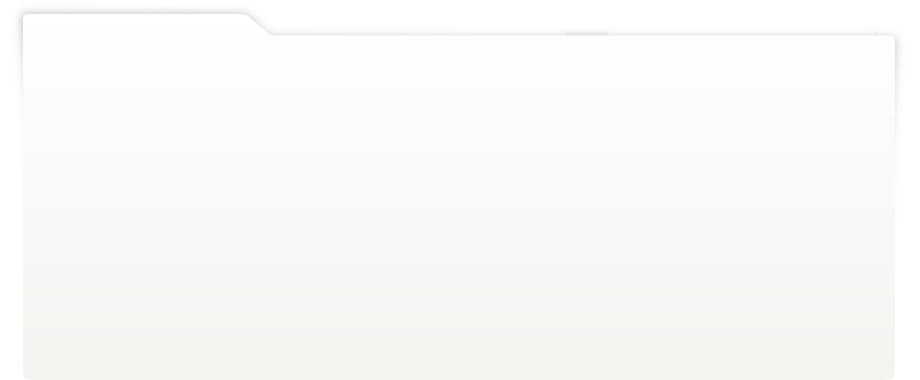
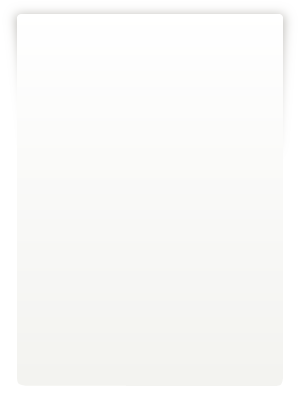
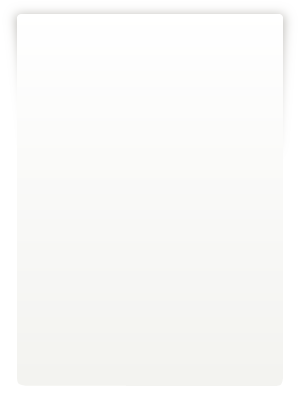
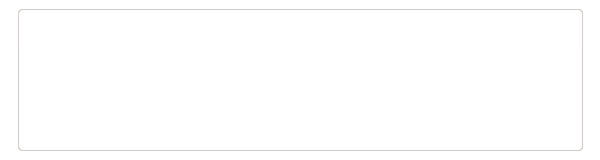
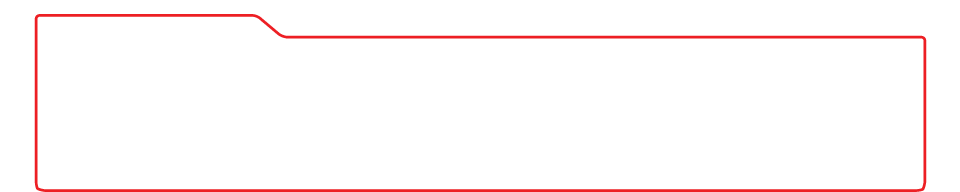
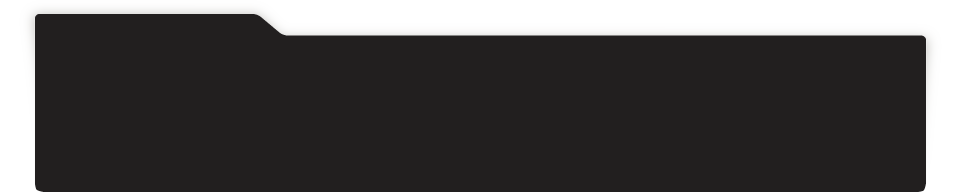
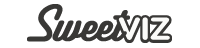
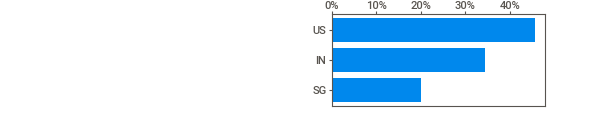
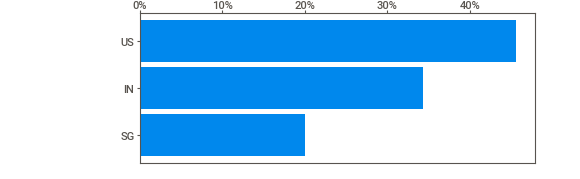
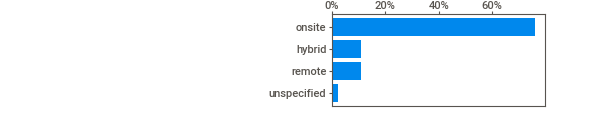
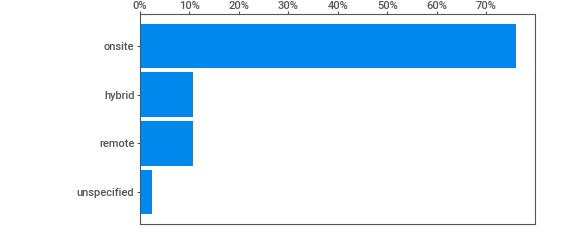
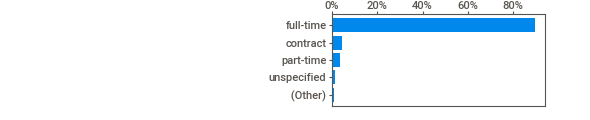
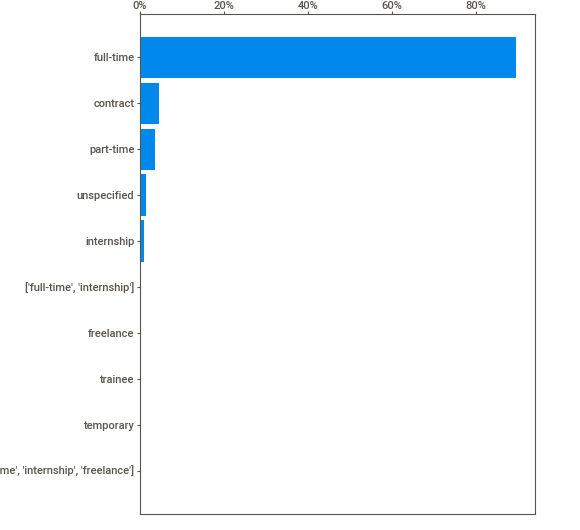
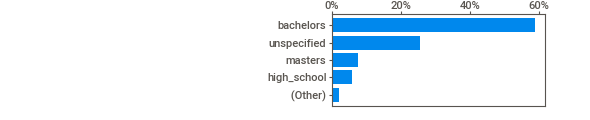
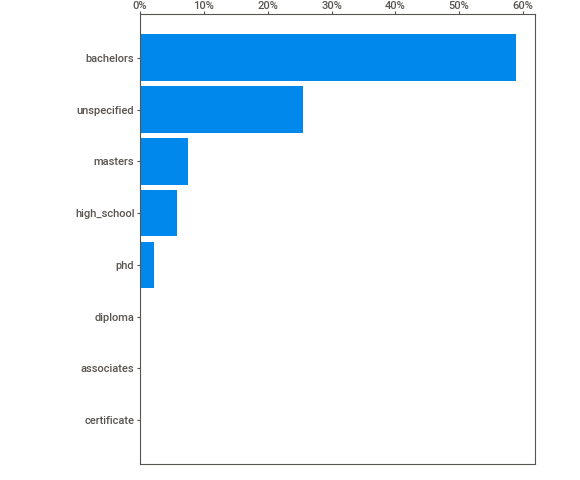
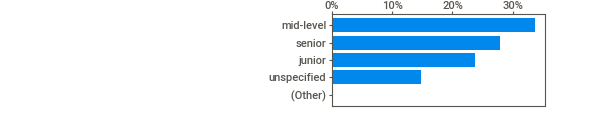
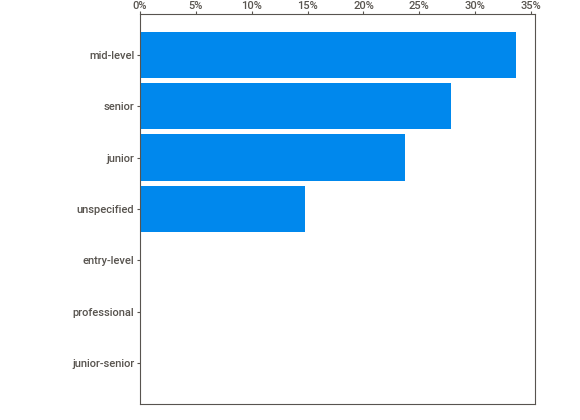
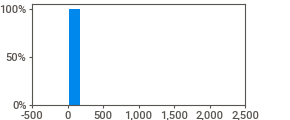
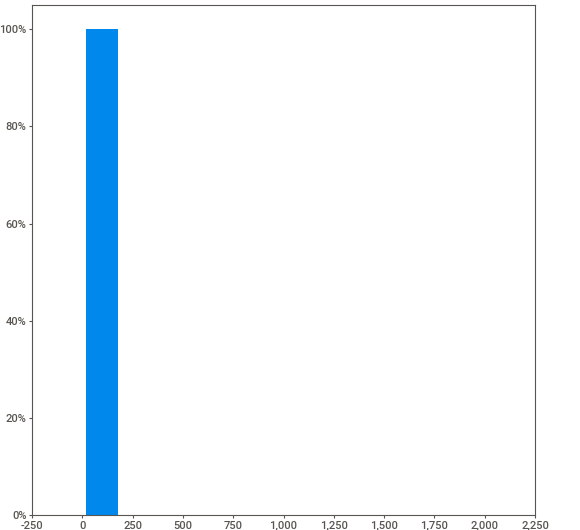
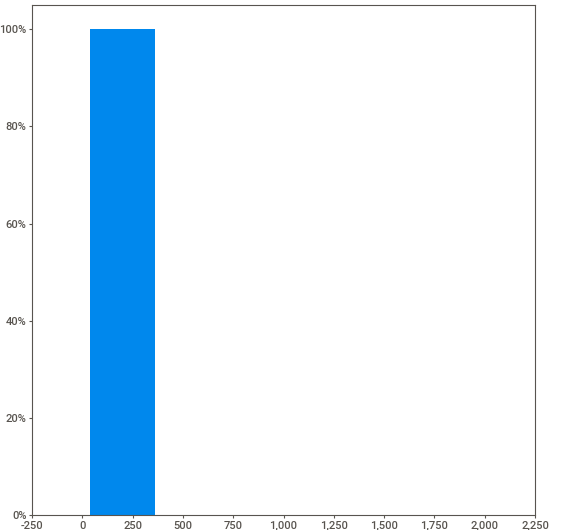
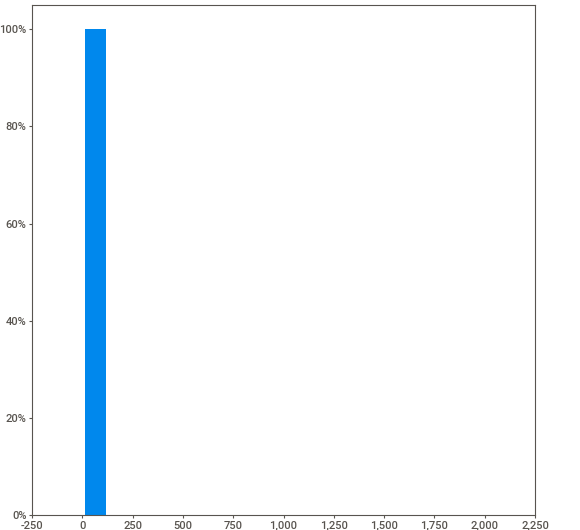
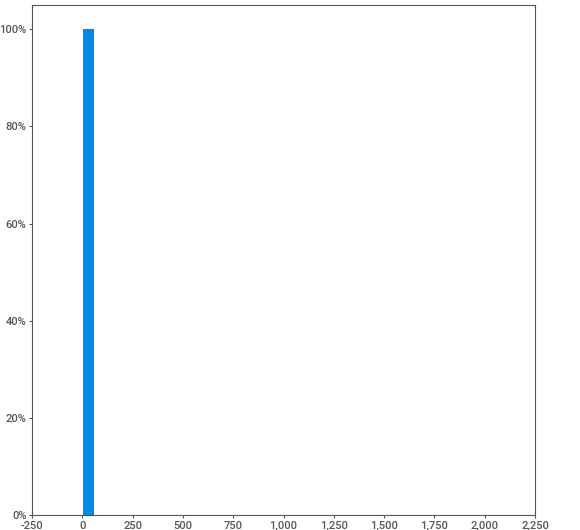
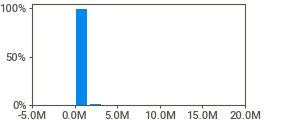
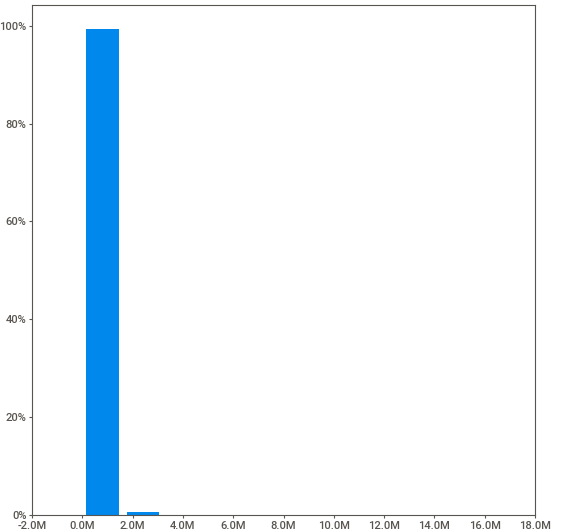
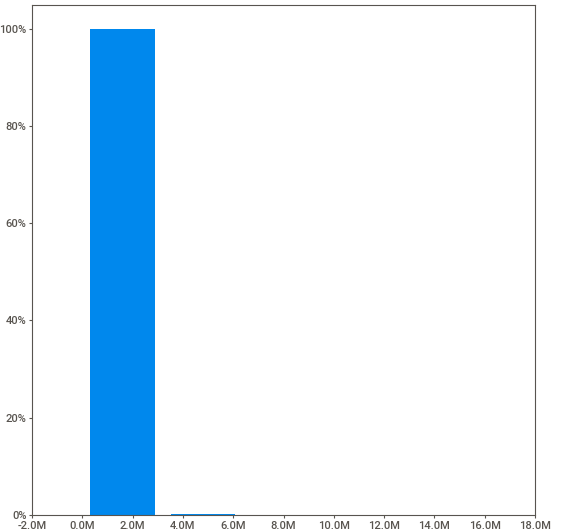
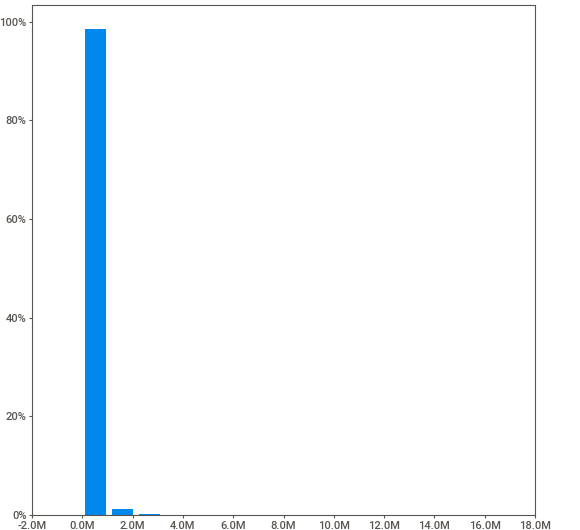
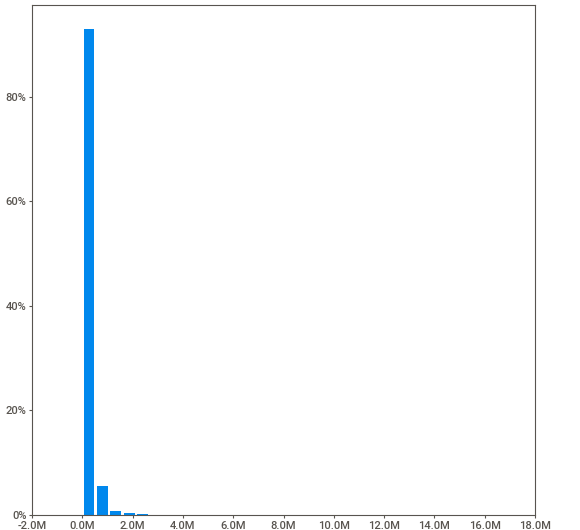
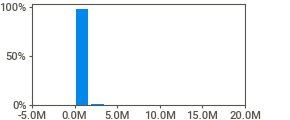
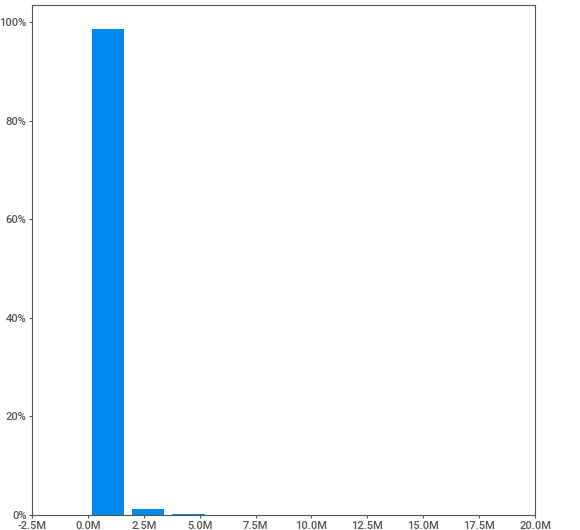
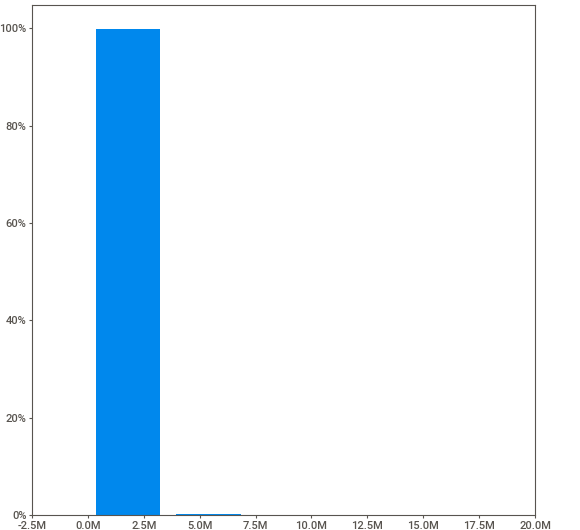
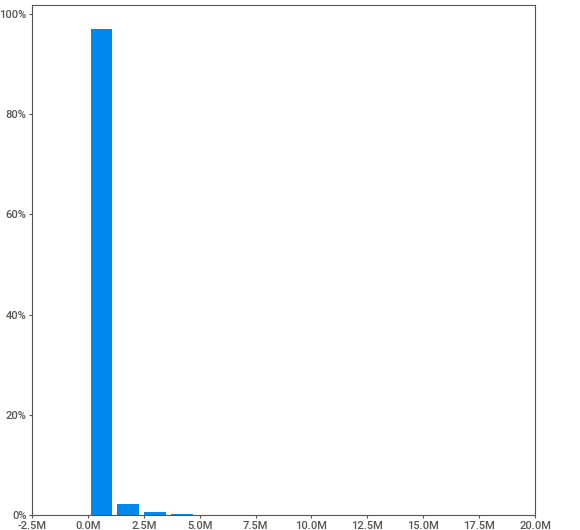
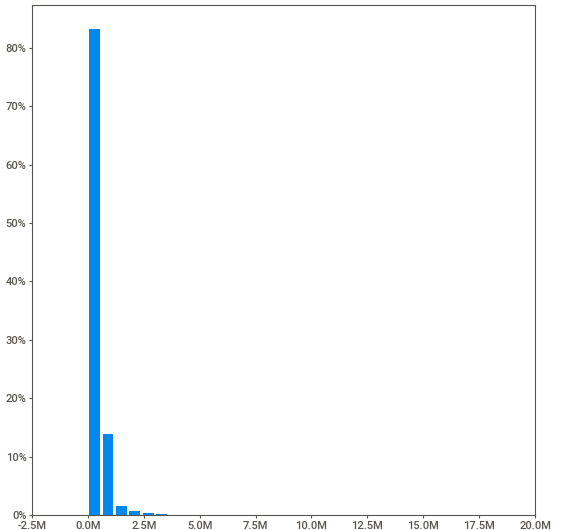
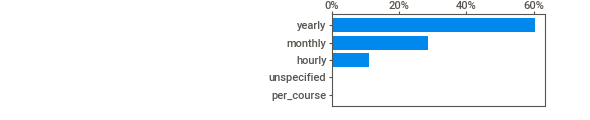
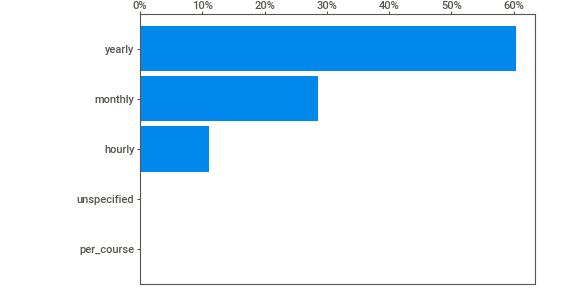
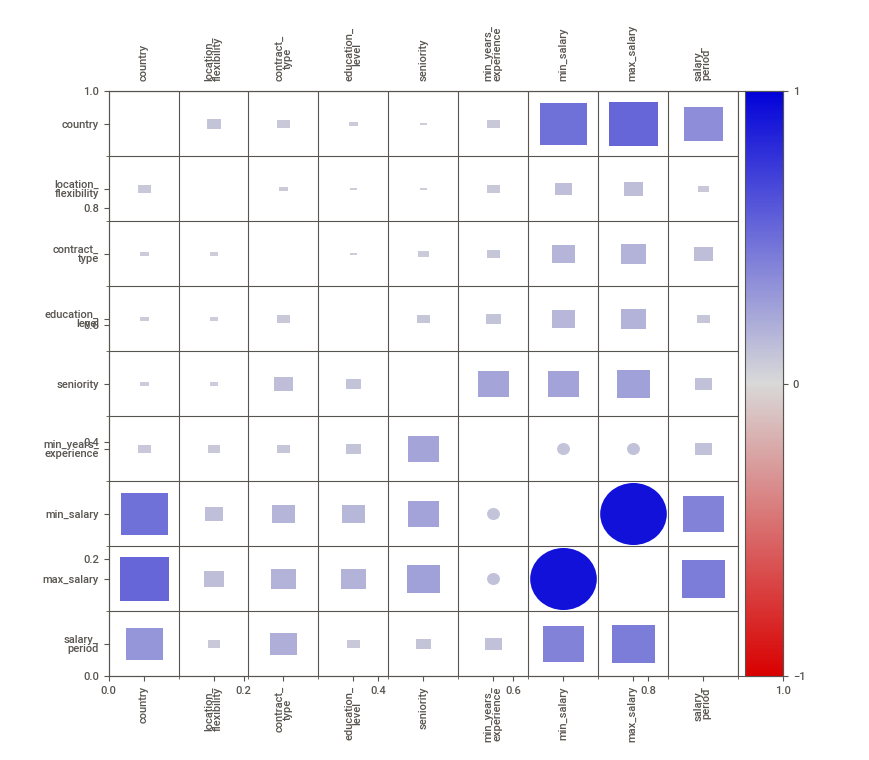
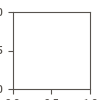

In [3]:
import sweetviz as sv

my_report = sv.analyze(pd.read_csv("jobs.csv"))

my_report.show_notebook()